# View CPT Results for experiment "20112012-adj-parties"

In [16]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (10, 7)

## Topic word perplexity

In [17]:
import os

def load_perplexity_results(results_dir):
    perplexity_topic = pd.read_csv(os.path.join(results_dir, 'perplexity_topic.csv'), index_col=0)
    perplexity_opinion = pd.read_csv(os.path.join(results_dir, 'perplexity_opinion.csv'), index_col=0)
    
    return perplexity_topic, perplexity_opinion

In [18]:
results_dir = '/home/jvdzwaan/data/dilipad/results/20112012/adj-parties/'

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=large. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


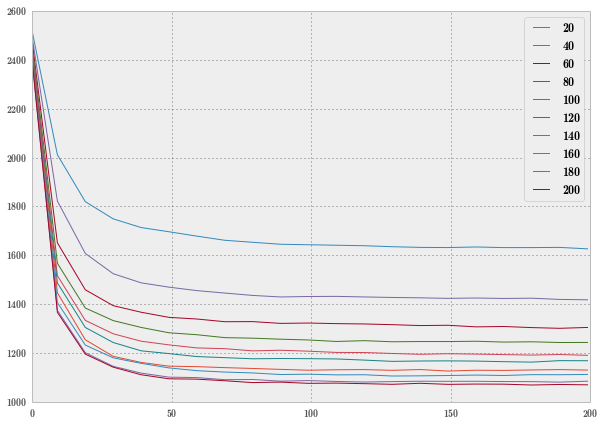

In [19]:
perplexity_topic, perplexity_opinion = load_perplexity_results(results_dir)
perplexity_topic.plot();

In [20]:
# change intervals if needed
intervals = ['20', '60', '80','100', '180', '160', '200']

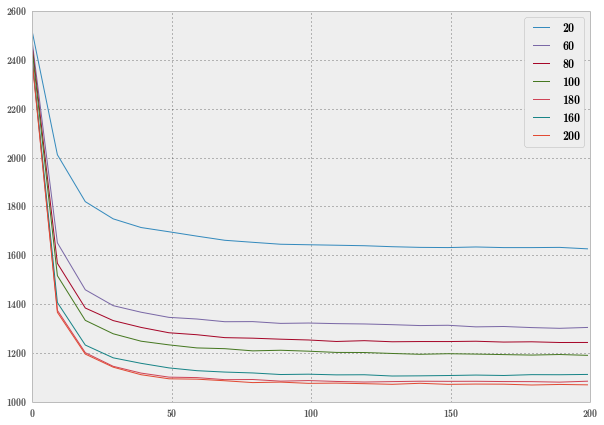

In [21]:
perplexity_topic[intervals].plot();

## Opinion word perplexity

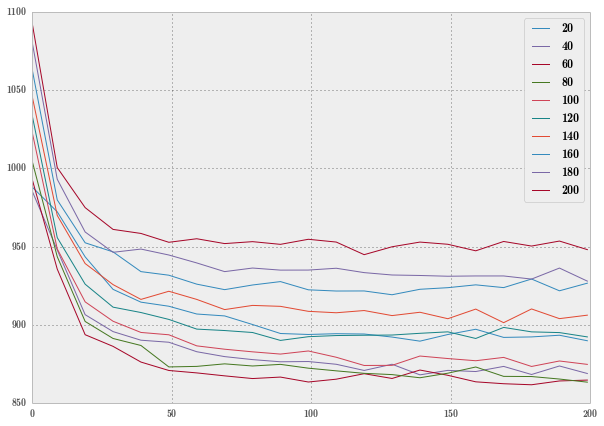

In [22]:
perplexity_opinion.plot();

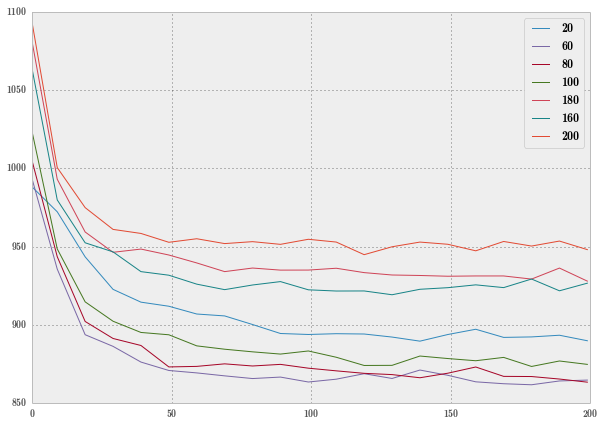

In [23]:
perplexity_opinion[intervals].plot();

## Results for topics and opinions

In [24]:
# choose optimal number of topics based on perplexity results
nTopics = 100

In [25]:
# load results
import glob
import os
import re

def load_experiment_results(nTopics, results_dir):

    # document topic matrix (theta)
    theta = pd.read_csv(os.path.join(results_dir, 'theta_{}.csv'.format(nTopics)), index_col=0)

    # phi topic (transposed)
    phi_topic_t = pd.read_csv(os.path.join(results_dir, 'topics_{}.csv'.format(nTopics)), index_col=0, encoding='utf-8')

    # phi opinion (transposed) per perspective
    opinion_files = glob.glob('{}/opinions_*_{}.csv'.format(results_dir, nTopics))
    phis_opinion_t = {}
    for f in opinion_files:
        m = re.match(r'.+opinions_(.+).csv', f)
        name = m.group(1).replace('_{}'.format(nTopics), '')
        phis_opinion_t[name] = pd.read_csv(f, index_col=0, encoding='utf-8')
    return theta, phi_topic_t, phis_opinion_t

In [26]:
theta, phi_topic_t, phis_opinion_t = load_experiment_results(nTopics, results_dir)

### 'Weight' of the most important topic per document

Each topic has a certain weight in the document. We would like to see one (or a few) topics with high weight per document. Below are some basic statistics on the most important topic (highest weight) per document. 

In [27]:
def print_topic_weights(theta):
    a = theta.copy().apply(max, axis=1)
    a.sort(ascending=False)

    print 'Mean weight of most important topic: {} (std: {})'.format(a.mean(), a.std())
    print 'Min and max of most important topic: min: {}, max: {}'.format(a.min(), a.max())
    print 'Median weight of most important topic: ', a.median()

print_topic_weights(theta)

Mean weight of most important topic: 0.16857450456 (std: 0.135252012523)
Min and max of most important topic: min: 0.01, max: 0.679574406485
Median weight of most important topic:  0.130808080808


Line graph of the sorted topic weigths:

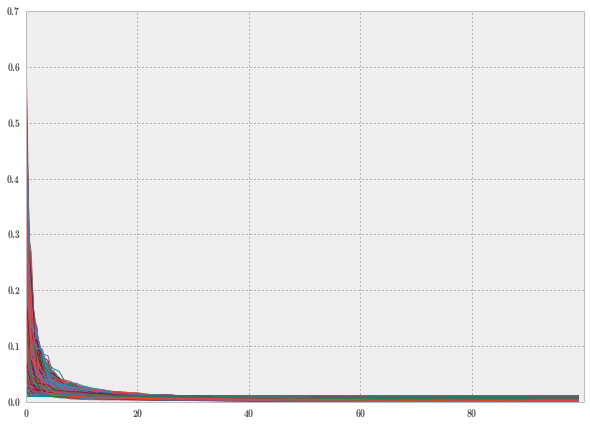

In [28]:
def plot_topic_weights(theta):
    theta.copy().apply(lambda row:sorted(row)[::-1], axis=1).transpose().plot(legend=None);

plot_topic_weights(theta)

### Number of topics per document

The number of topics per document is calculated by counting the number of topic with weight above a certain threshold. The numer of topics per document should (roughly) be equivalent to the number of ``pm:topic``s per document (however, at the moment we do not have statistics of this).

0     950
4     176
1    1329
5      53
2    1187
6       7
3     598
7       1
dtype: int64


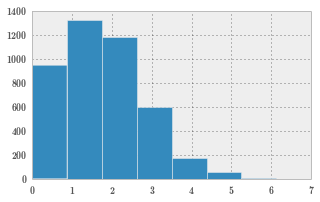

In [29]:
def display_number_of_topics_per_document(theta, threshold=0.05):
    topic_counts = theta.apply(lambda row: np.sum(row > threshold), axis=1)
    print topic_counts.value_counts(sort=False)
    topic_counts.hist(bins=len(topic_counts.value_counts()), figsize=(5,3));

display_number_of_topics_per_document(theta)

### Topics

In [30]:
def show_topic(t, top=10):
    """Return dataframe containing <top> topic words, weights of topic words and per perspective opinion words and
    weigths of opinion words.
    
    Parameters
        t : str - index of topic number
        top : int - the number of words to store in the dataframe
    
    Returns Pandas DataFrame
    """
    topic = phi_topic_t[t].copy()
    topic.sort(ascending=False)
    topic = topic[0:top]
    df_t = pd.DataFrame(topic)
    df_t.reset_index(level=0, inplace=True)
    df_t.columns = ['topic_{}'.format(t), 'weights_topic_{}'.format(t)]

    dfs = [df_t]

    for p, o in phis_opinion_t.iteritems():
        opinion = o[t].copy()
        opinion.sort(ascending=False)
        opinion = opinion[0:top]
        df_o = pd.DataFrame(opinion)
        df_o.reset_index(level=0, inplace=True)
        df_o.columns = ['opinion_{}_{}'.format(t, p), 'weights_opinion_{}_{}'.format(t, p)]
        dfs.append(df_o)
        
    return pd.concat(dfs, axis=1)

def print_topics(phi_topic_t, phis_opinion_t, nTopics):
    jsd = None
    jsdFile = os.path.join(results_dir, 'jsd_{}.csv'.format(nTopics))
    if os.path.isfile(jsdFile):
        print 'Ordering topics by Jensen-Shannon divergence of the opinions'
        print
        jsd = pd.read_csv(jsdFile, index_col=0)
        r = jsd.sort(['jsd'], ascending=False)
        print 'Min jsd: {}, max jsd: {}'.format(np.min(jsd['jsd']), np.max(jsd['jsd']))
        print 'Average jsd: {} (std: {}), median jsd: {}'.format(np.mean(jsd['jsd']), np.std(jsd['jsd']), np.median(jsd['jsd']))
        print
        loop = r.index
    else:
        print 'Ordering topics by topic number'
        print '(To order topics by Jensen-Shannon divergence of the opinions run the experiment_jsd_opinions script.)'
        print
        loop = range(nTopics)
    for i in loop:
        if not jsd is None:
            print 'JSD:', jsd.at[i, 'jsd']
        pLabels = ['opinion_{}_{}'.format(i, p) for p, o in phis_opinion_t.iteritems()]
        print show_topic(str(i))[['topic_{}'.format(i)] + pLabels]
        print

In [31]:
print_topics(phi_topic_t, phis_opinion_t, nTopics)

Ordering topics by Jensen-Shannon divergence of the opinions

Min jsd: 0.568492220109, max jsd: 0.926441393898
Average jsd: 0.729723969763 (std: 0.0692875789176), median jsd: 0.728102520581

JSD: 0.926441393898
          topic_5     opinion_5_PvdD   opinion_5_D66          opinion_5_CDA  \
0            euro       democratisch  institutioneel      gemeenschappelijk   
1            unie           monetair     buitenlands             essentieel   
2          crisis        gezamenlijk           duits  financieel-economisch   
3        lidstaat             grieks            zwak                 intern   
4           markt           vergaand    democratisch               ongekend   
5     bevoegdheid  gemeenschappelijk     afdwingbaar              onderling   
6            munt         onmogelijk    fundamenteel              zuidelijk   
7       bevolking          zuidelijk          intern               speciaal   
8  soevereiniteit               rijk        moeizaam               monetair   

[(u'student', 0.14678027509800001), (u'institution', 0.056880668573599996), (u'study', 0.047981211215199993), (u'education', 0.0385480979866), (u'loan_system', 0.025779497702900004), (u'diploma', 0.023537702802300001), (u'academy', 0.021485685447800003), (u'university', 0.017397748978299998), (u'term_exceedance_fine', 0.015579851182899999), (u'performance_agreement', 0.014957153018399999)]


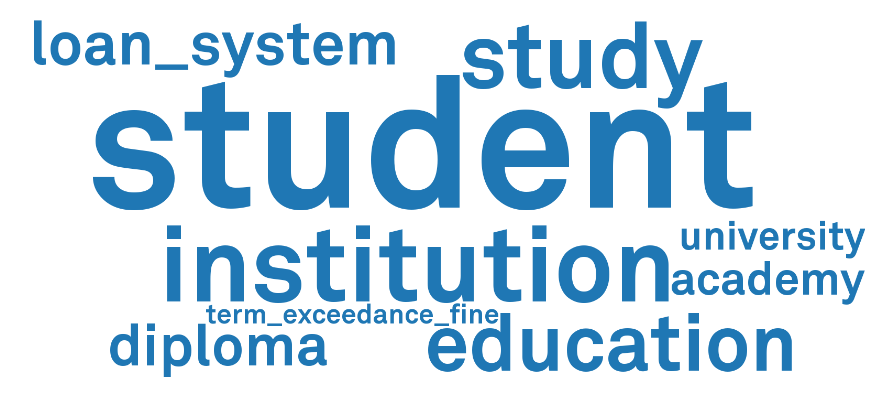

In [94]:
from wordcloud import WordCloud

def single_color(*args, **kwargs):
    return '#1f77b4'

# - color
# - 2 colors
# - translation
font = '/home/jvdzwaan/.local/share/fonts/Akkurat-Bold.ttf'

topic = str(59)

data = show_topic(topic, 10)

#print data.columns
words = [w for w in data['topic_{}'.format(topic)]]
words = [u'student', u'institution', u'study', u'education', u'loan_system', u'diploma', 
         u'academy', u'university', u'term_exceedance_fine', u'performance_agreement']
weigths = [w for w in data['weights_topic_{}'.format(topic)]]

words = zip(words, weigths)
words = sorted(words, key=lambda x: x[1], reverse=True)
print words

wc = WordCloud(relative_scaling=0.7, prefer_horizontal=1.0, background_color="white", 
               height=700, width=1600, font_path=font, color_func=single_color,
               min_font_size=50, max_font_size=350).fit_words(words)
# font_path=font
plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.show()

Index([u'topic_59', u'weights_topic_59', u'opinion_59_PvdD', u'weights_opinion_59_PvdD', u'opinion_59_D66', u'weights_opinion_59_D66', u'opinion_59_CDA', u'weights_opinion_59_CDA', u'opinion_59_PvdA', u'weights_opinion_59_PvdA', u'opinion_59_GroenLinks', u'weights_opinion_59_GroenLinks', u'opinion_59_SGP', u'weights_opinion_59_SGP', u'opinion_59_SP', u'weights_opinion_59_SP', u'opinion_59_PVV', u'weights_opinion_59_PVV', u'opinion_59_50PLUS', u'weights_opinion_59_50PLUS', u'opinion_59_ChristenUnie', u'weights_opinion_59_ChristenUnie', u'opinion_59_VVD', u'weights_opinion_59_VVD', u'opinion_59_OSF', u'weights_opinion_59_OSF'], dtype='object')
[u'perversely', u'extraordinary', u'structural', u'strict', u'outstanding', u'actual', u'agreed', u'unfair', u'bureaucratic', u'originating']
[u'technical', u'interesting', u'finished', u'excellent', u'logical', u'practical', u'shady', u'blank', u'angry', u'pragmatic']


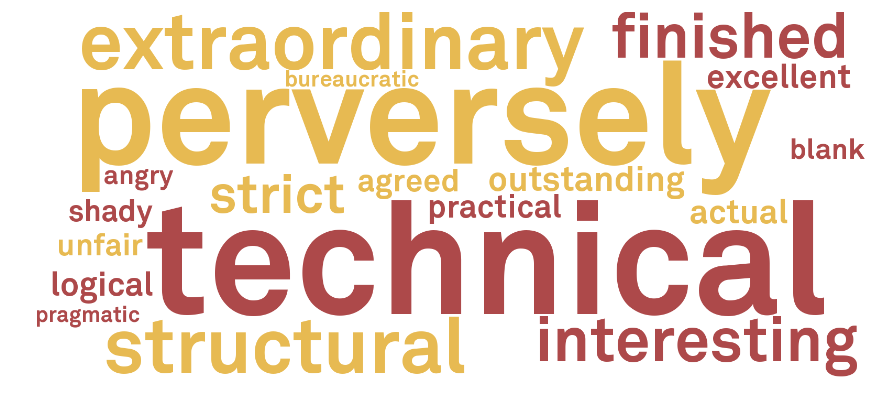

[((u'technical', 1.0), 300, (361, 224), None, '#ad494a'), ((u'perversely', 0.86331337566265409), 271, (94, 81), None, '#e7ba52'), ((u'extraordinary', 0.68318935303129824), 152, (1, 97), None, '#e7ba52'), ((u'structural', 0.65610776634678958), 148, (583, 145), None, '#e7ba52'), ((u'interesting', 0.59510338133675023), 120, (582, 968), None, '#ad494a'), ((u'finished', 0.59155425932913819), 119, (1, 1114), None, '#ad494a'), ((u'strict', 0.47665291524832148), 103, (311, 345), None, '#e7ba52'), ((u'outstanding', 0.47637801698301196), 66, (296, 878), None, '#e7ba52'), ((u'actual', 0.45547727220110773), 64, (358, 1263), None, '#e7ba52'), ((u'excellent', 0.45480274157513395), 64, (100, 1295), None, '#ad494a'), ((u'logical', 0.44898072656449645), 63, (496, 42), None, '#ad494a'), ((u'practical', 0.43157735581551815), 61, (349, 762), None, '#ad494a'), ((u'agreed', 0.41913901232156031), 60, (301, 629), None, '#e7ba52'), ((u'unfair', 0.40192118439938113), 58, (423, 55), None, '#e7ba52'), ((u'shady',

In [98]:
print data.columns
p1_words = [w for w in data['opinion_{}_SP'.format(topic)]]
p1_words = [u'perversely', u'extraordinary', u'structural', u'strict', u'outstanding', u'actual', u'agreed', 
            u'unfair', u'bureaucratic', u'originating']
print p1_words
p1_weights = [w for w in data['weights_opinion_{}_SP'.format(topic)]]
p2_words = [w for w in data['opinion_{}_D66'.format(topic)]]
p2_words = [u'technical', u'interesting', u'finished', u'excellent', u'logical', u'practical', u'shady', 
            u'blank', u'angry', u'pragmatic']
print p2_words
p2_weights = [w for w in data['weights_opinion_{}_D66'.format(topic)]]
words = zip(p1_words+p2_words, p1_weights+p2_weights)
words = sorted(words, key=lambda x: x[1], reverse=True)

def topic59_color(word=word, *args, **kwargs):
    if word in p1_words:
        return '#e7ba52'
    else:
        return '#ad494a'

wc = WordCloud(relative_scaling=0.7, prefer_horizontal=1.0, background_color="white", 
               height=700, width=1600, font_path=font, color_func=topic59_color,
               min_font_size=40, max_font_size=300).fit_words(words)
# font_path=font
plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.show()

print wc.layout_

[u'taal', u'integratie', u'inburgering', u'migrant', u'immigrant', u'examen', u'vrouw', u'vluchteling', u'klaveren', u'niveau']
[(u'language', 0.050829699490400004), (u'integration', 0.041282586860100001), (u'civic_integration', 0.0312155079275), (u'migrant', 0.027405371914700001), (u'immigrant', 0.0201889553893), (u'exam', 0.019383113597400001), (u'woman', 0.018730986557599999), (u'refugee', 0.016544427235800001), (u'Klaveren', 0.016530756405399999), (u'level', 0.015702324555300001)]


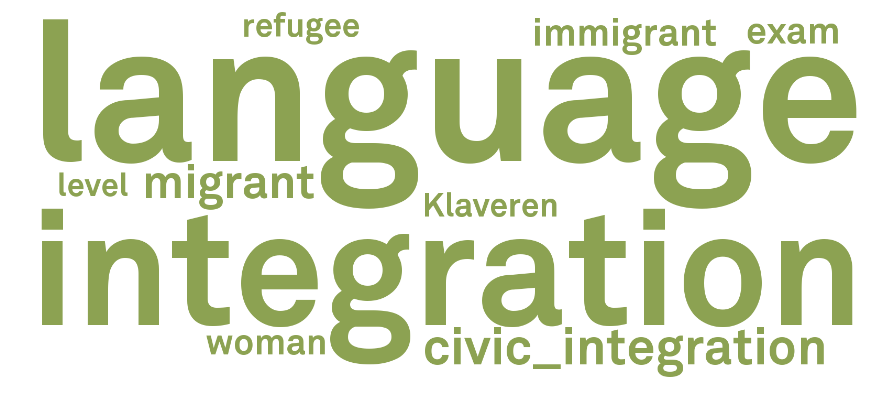

In [101]:
def single_color2(*args, **kwargs):
    return '#8ca252'

topic = str(78)

data = show_topic(topic, 10)

#print data.columns
words = [w for w in data['topic_{}'.format(topic)]]
print words
words = [u'language', u'integration', u'civic_integration', u'migrant', u'immigrant', u'exam', u'woman', u'refugee', 
         u'Klaveren', u'level']
weigths = [w for w in data['weights_topic_{}'.format(topic)]]

words = zip(words, weigths)
words = sorted(words, key=lambda x: x[1], reverse=True)
print words

wc = WordCloud(relative_scaling=0.7, prefer_horizontal=1.0, background_color="white", 
               height=700, width=1600, font_path=font, color_func=single_color2,
               min_font_size=50, max_font_size=400).fit_words(words)
# font_path=font
plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.show()

[u'vrijwillig', u'humaan', u'islamitisch', u'kennelijk', u'marokkaans', u'religieus', u'normaal', u'maximaal', u'turks', u'voldoen']
[u'bewust', u'niet-westers', u'goedkoop', u'zelfstandig', u'gek', u'zorgelijk', u'vrijwillig', u'verwijtbaar', u'inburgeringsplichtig', u'makkelijk']


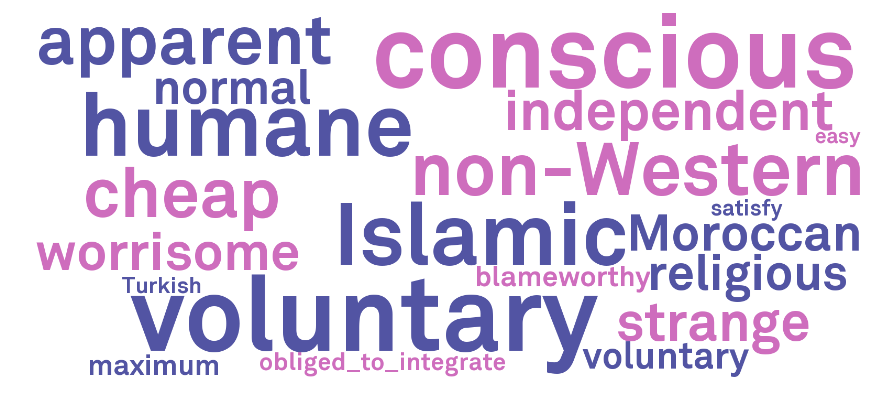

[((u'voluntary', 1.0), 200, (502, 196), None, '#5254a3'), ((u'conscious', 0.97773010052072484), 197, (4, 657), None, '#ce6dbd'), ((u'humane', 0.77967079457470112), 169, (154, 98), None, '#5254a3'), ((u'Islamic', 0.76023163710337127), 166, (363, 583), None, '#5254a3'), ((u'non-Western', 0.72743068118577714), 142, (250, 729), None, '#ce6dbd'), ((u'cheap', 0.66069618207221148), 133, (297, 105), None, '#ce6dbd'), ((u'apparent', 0.65172433197096202), 132, (11, 16), None, '#5254a3'), ((u'independent', 0.64887862049397316), 107, (150, 908), None, '#ce6dbd'), ((u'strange', 0.62512258653591402), 104, (557, 1123), None, '#ce6dbd'), ((u'worrisome', 0.61111646673253772), 102, (421, 14), None, '#ce6dbd'), ((u'Moroccan', 0.56597575191974492), 97, (388, 1143), None, '#5254a3'), ((u'religious', 0.55101308004448935), 95, (463, 1183), None, '#5254a3'), ((u'normal', 0.52921718931341066), 92, (111, 238), None, '#5254a3'), ((u'voluntary', 0.49916222788345072), 71, (630, 1058), None, '#5254a3'), ((u'blamewo

In [106]:
p1_words = [w for w in data['opinion_{}_PvdA'.format(topic)]]
print p1_words
p1_words = [u'voluntary', u'humane', u'Islamic', u'apparent', u'Moroccan', u'religious', u'normal', 
            u'maximum', u'Turkish', u'satisfy']
p1_weights = [w for w in data['weights_opinion_{}_PvdA'.format(topic)]]
p2_words = [w for w in data['opinion_{}_VVD'.format(topic)]]
print p2_words
p2_words = [u'conscious', u'non-Western', u'cheap', u'independent', u'strange', u'worrisome', 
            u'voluntary', u'blameworthy', u'obliged_to_integrate', u'easy']
p2_weights = [w for w in data['weights_opinion_{}_VVD'.format(topic)]]
words = zip(p1_words+p2_words, p1_weights+p2_weights)
words = sorted(words, key=lambda x: x[1], reverse=True)

def topic59_color(word, *args, **kwargs):
    if word==u'vrijwillig' and kwargs['font_size']<200:
        return '#ce6dbd'
    elif word in p1_words or ():
        return '#5254a3'
    else:
        return '#ce6dbd'

wc = WordCloud(relative_scaling=0.7, prefer_horizontal=1.0, background_color="white", 
               height=700, width=1600, font_path=font, color_func=topic59_color,
               min_font_size=40, max_font_size=200).fit_words(words)
# font_path=font
plt.figure(figsize=(15,15))
plt.imshow(wc)
plt.axis("off")
plt.show()

print wc.layout_